In [1]:
import sys, os
sys.path.append('/cr/users/filip/bin/')

# from utils.Auger.SD import Monitoring

from utils.binaries import *
from utils.plotting import *

15:13:26 [INFO] utils          -- (+14575ms) -- import logging
15:13:26 [INFO] utils.binaries -- (   +89ms) -- import numpy as np
15:13:26 [INFO] utils.binaries -- (  +167ms) -- import pandas as pd
15:13:26 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools
15:13:27 [INFO] utils.plotting -- (  +470ms) -- import matplotlib.pyplot as plt
15:13:27 [INFO] utils.plotting -- (  +250ms) -- import seaborn as so
15:13:27 [DBUG] utils.plotting -- (    +6ms) -- font size set to 9.5
15:13:27 [DBUG] utils.plotting -- (    +1ms) -- label size set to 13.0
15:13:27 [DBUG] utils.plotting -- (    +1ms) -- figure size set to [6.6, 3.3]
15:13:27 [DBUG] utils.plotting -- (    +1ms) -- markersize set to 2.0
15:13:27 [DBUG] utils.plotting -- (    +1ms) -- usetex set to False
15:13:27 [INFO] utils.plotting -- (    +2ms) -- import plotting.tools as plot


In [2]:
thresholds = np.round(np.arange(1.0, 5.01, 0.05), 2)
data = pd.read_csv('/cr/tempdata01/filip/SSDCalib/BootstrapHistos/rates.txt', sep=' ', index_col=False)

data = data.dropna()
# data = data.drop(data[data['#id'] == 734].index)
# data = data.drop(data[data['#id'] == 1732].index)

# in UUB RANDOMS STATIONS FROM {Dec, Mar, Jun, Sep} 2021-2023
# 29681 events in dataset before fitting algorithm rework
# 44958 events in dataset AFTER fitting algoritm reworked

# in ALL STATIONS in {Jun, Dec} 2023
# 869_609 showers

In [3]:
data

,#id,t,mip,1.0xmip,1.05xmip,1.1xmip,1.15xmip,1.2xmip,1.25xmip,1.3xmip,...,4.55xmip,4.6xmip,4.65xmip,4.7xmip,4.75xmip,4.8xmip,4.85xmip,4.9xmip,4.95xmip,5.0xmip
0,692,1369621695,47.41,255.52,235.34,215.90,197.77,180.72,163.79,149.34,...,1.69,1.59,1.44,1.39,1.36,1.34,1.30,1.25,1.25,1.21
1,1714,1369621700,44.27,221.75,205.62,190.41,175.77,161.28,147.30,133.80,...,1.77,1.62,1.61,1.54,1.48,1.46,1.34,1.30,1.25,1.20
2,612,1369621675,42.34,259.13,239.30,219.62,200.44,182.21,166.03,150.98,...,1.41,1.33,1.31,1.30,1.18,1.08,1.05,1.02,0.95,0.90
3,823,1369622202,45.21,226.16,210.62,195.03,179.90,165.36,150.84,138.20,...,1.92,1.89,1.87,1.80,1.72,1.66,1.56,1.44,1.33,1.31
4,1800,1369622200,46.17,235.05,217.28,201.56,186.10,171.51,157.41,143.44,...,1.67,1.66,1.62,1.56,1.52,1.48,1.46,1.41,1.31,1.26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
874075,449,1388110105,38.93,166.85,155.46,144.00,133.56,122.48,112.03,103.00,...,1.49,1.46,1.38,1.34,1.31,1.21,1.16,1.13,1.08,1.07
874076,424,1388110087,38.68,149.84,138.75,128.48,117.54,106.85,97.34,89.08,...,1.11,1.08,1.08,1.03,1.00,0.92,0.92,0.89,0.84,0.84
874077,423,1388110138,37.25,171.77,162.03,150.57,139.43,128.80,119.49,110.54,...,1.48,1.44,1.44,1.43,1.39,1.36,1.26,1.25,1.16,1.15
874078,407,1388110113,40.72,213.10,196.28,179.87,164.49,149.62,135.57,122.93,...,1.49,1.43,1.38,1.34,1.31,1.25,1.21,1.18,1.15,1.15


In [4]:
from scipy.stats import zscore

# remove station specific outliers (3 sigma)
data_wo_outliers = pd.DataFrame([], columns=data.columns)
for station in np.unique(data['#id']):
    mask = data['#id'] == station
    df = data[mask]
    n_orig = len(df)

    for col in df.columns:
        if not col.endswith('xmip'): continue
        df = df.drop(df[np.abs(zscore(df[col])) > 3].index)
    
    n_wo_outlier = len(df)
    data_wo_outliers = pd.concat([data_wo_outliers, df])

    print(f"{n_orig - n_wo_outlier} outliers removed for station {station}...")

91 outliers removed for station 56...
93 outliers removed for station 101...
5 outliers removed for station 102...
38 outliers removed for station 103...
71 outliers removed for station 104...
64 outliers removed for station 105...
39 outliers removed for station 106...
26 outliers removed for station 107...
80 outliers removed for station 108...
63 outliers removed for station 109...
97 outliers removed for station 110...
56 outliers removed for station 111...
46 outliers removed for station 112...
35 outliers removed for station 113...
56 outliers removed for station 114...
52 outliers removed for station 115...
65 outliers removed for station 116...
80 outliers removed for station 117...
16 outliers removed for station 118...
63 outliers removed for station 119...
101 outliers removed for station 121...
64 outliers removed for station 122...
39 outliers removed for station 123...
14 outliers removed for station 124...
48 outliers removed for station 125...
41 outliers removed for st

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(286.62445068359375, 0.5, 'Rate above $1.75\\,\\mathrm{MIP}_\\mathrm{Peak}$ / Hz')

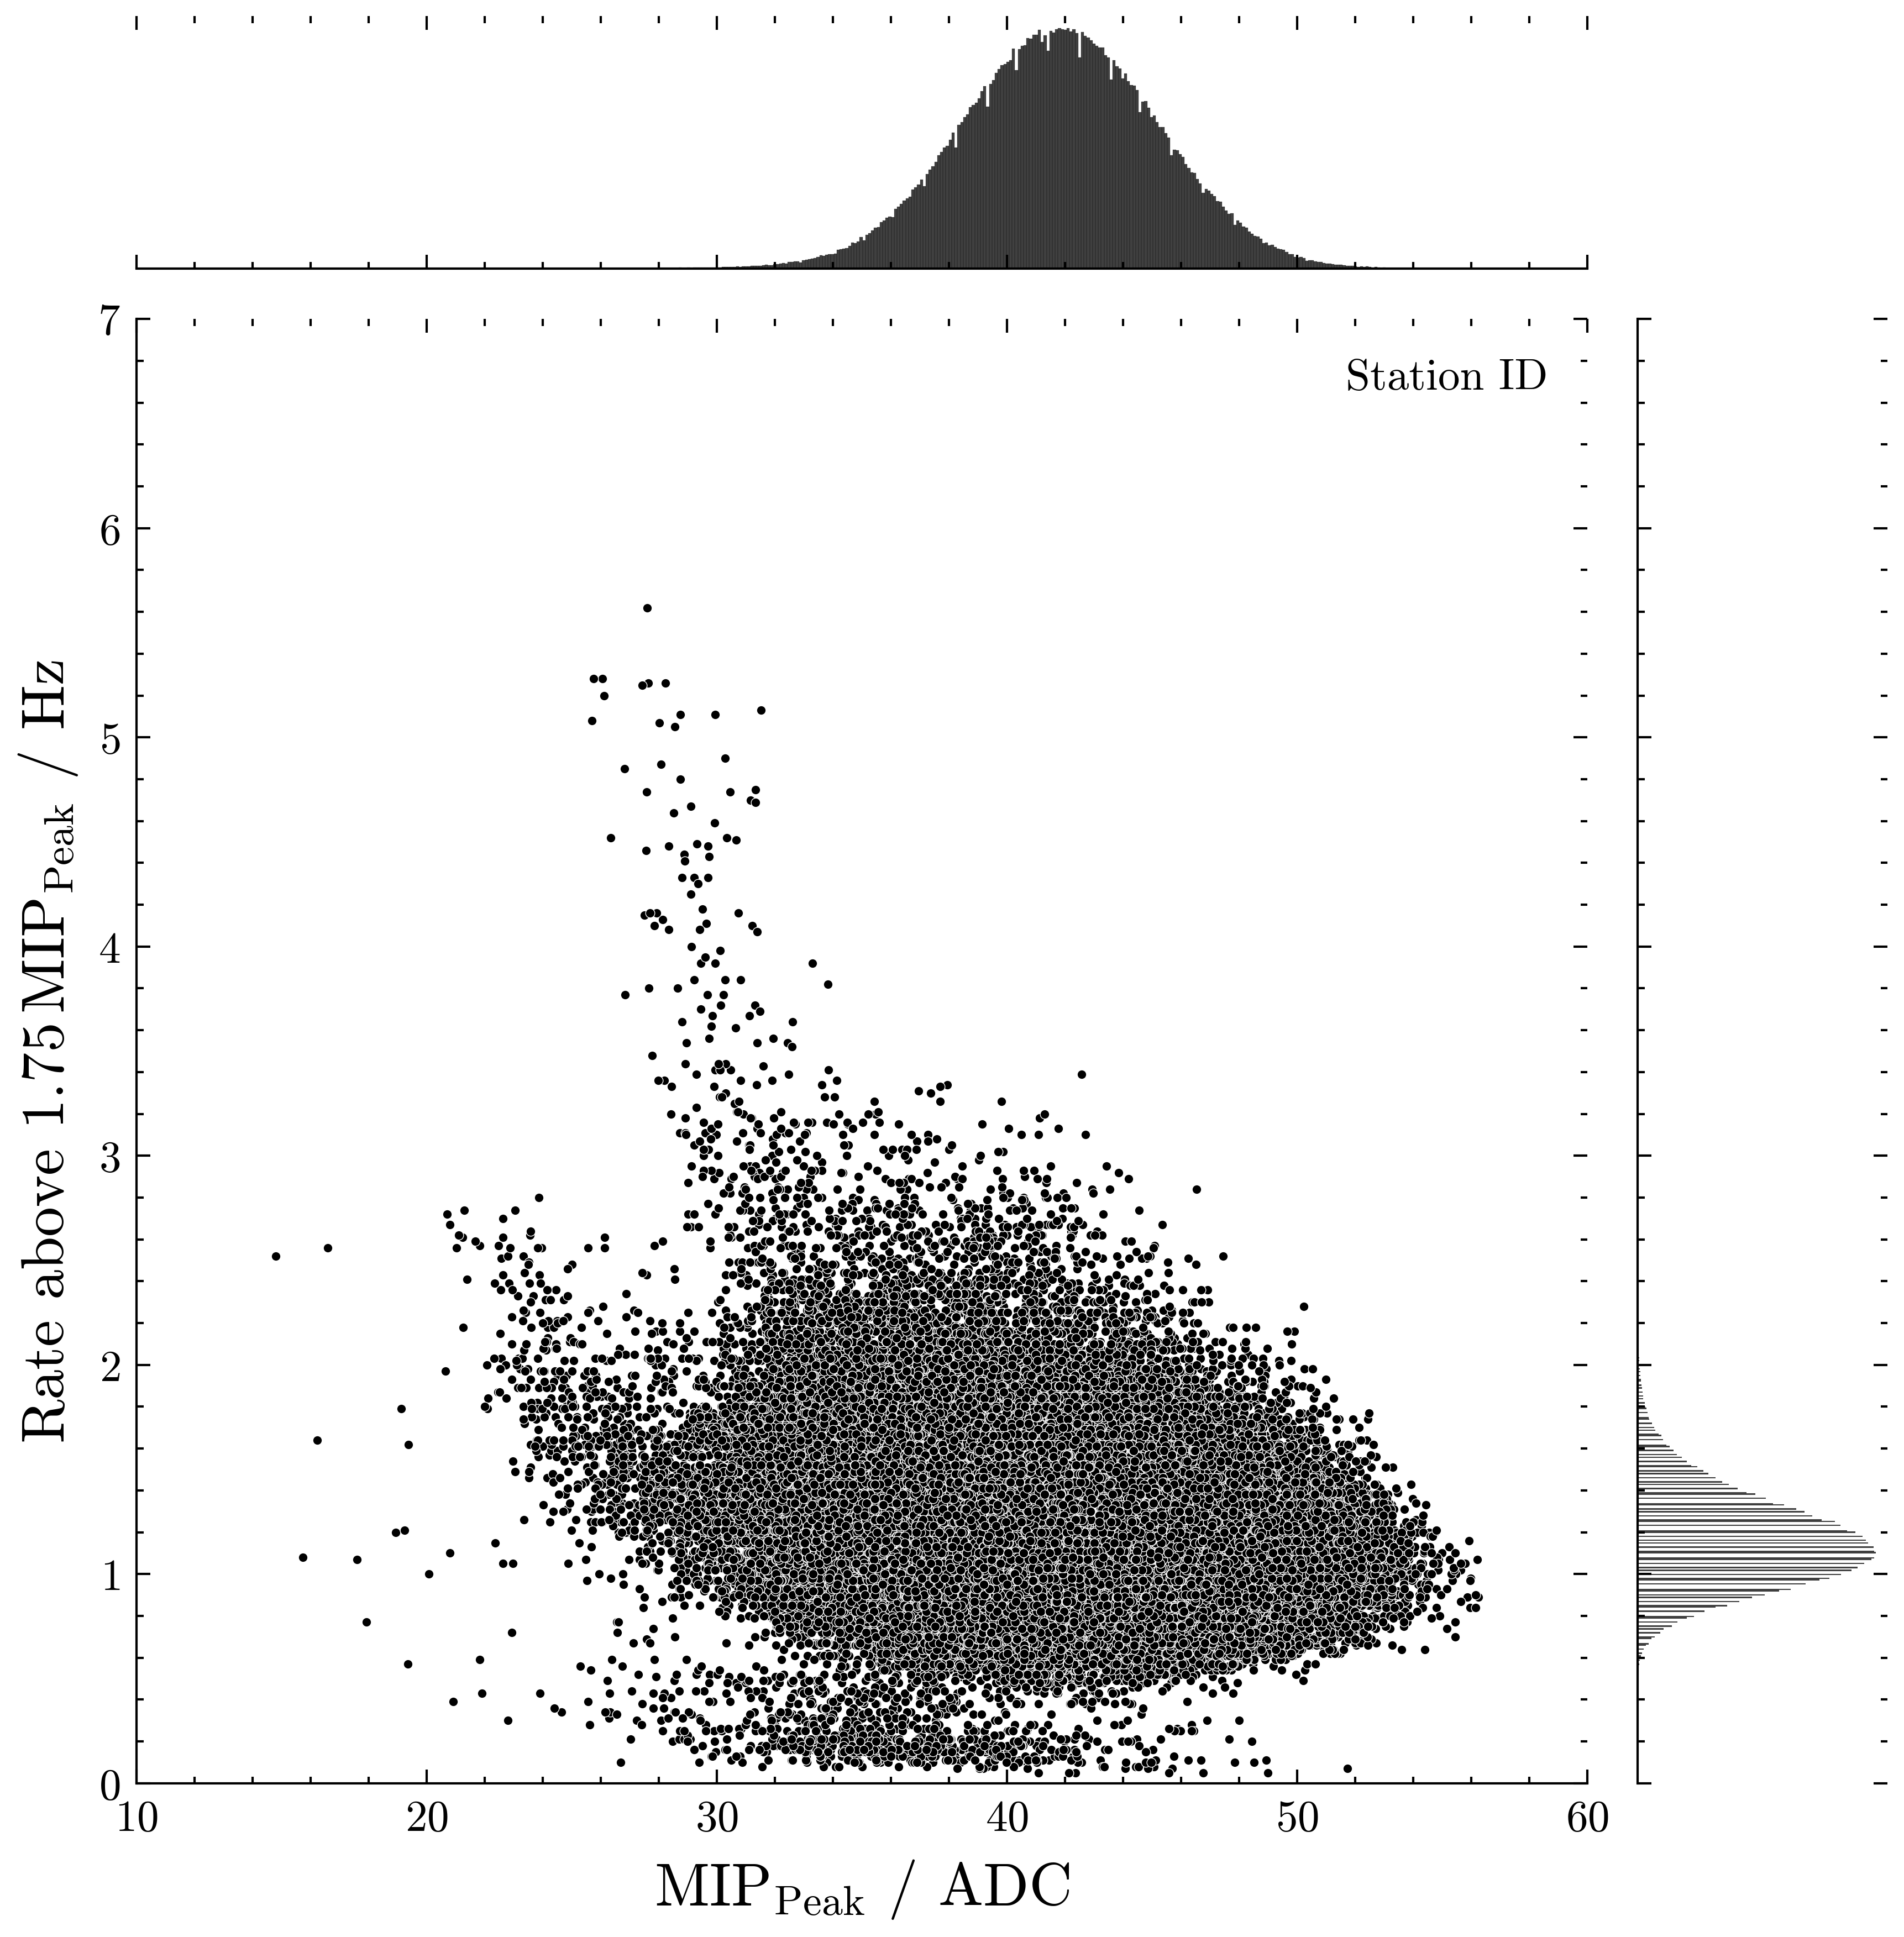

In [9]:
so.jointplot(data_wo_outliers, x='mip', y='5.0xmip', palette='tab10')
plt.xlim(10, 60)
plt.ylim(0, 7)
plt.legend(title='Station ID')
plt.xlabel('$\mathrm{MIP}_\mathrm{Peak}$ / ADC')
plt.ylabel('Rate above $1.75\,\mathrm{MIP}_\mathrm{Peak}$ / Hz')

In [ ]:
thresholds = np.round(np.arange(1.0, 5.01, 0.05), 2)
ax = plt.gca()

_ = plt.violinplot([data_wo_outliers[f"{t}xmip"].values for t in thresholds], 
                   positions=thresholds, 
                   widths=0.05,
                   showmeans=True)

rates = np.array([data_wo_outliers[f"{t}xmip"].mean() for t in thresholds])
sigma_sys = np.array([data_wo_outliers[f"{t}xmip"].std() for t in thresholds]) / rates
sigma_stat = 1/np.sqrt(rates * 61)
sigma = np.sqrt(sigma_sys ** 2 + sigma_stat ** 2)

error = ax.twinx()
error.plot(thresholds, sigma_stat, label=r"$\sigma_\mathrm{stat.}$", c='r', ls='--')
error.plot(thresholds, sigma_sys, label=r"$\sigma_{\mathrm{sys.}}$", c='b', ls=':')
error.plot(thresholds, sigma, label=r"$\sqrt{\Sigma_i\,\sigma_i^2}$", c='g', ls='-.')

ax.plot([], [], label=r"$\sigma_\mathrm{stat.}$")
ax.plot([], [],label=r"$\sigma_{\mathrm{sys.}}$")
ax.plot([], [], label=r"$\sqrt{\Sigma_i\,\sigma_i^2}$")
ax.errorbar([],[], [], label='Events', fmt='ko', ls=None, capsize=2)
ax.set_xlabel("Threshold / MIP peak")
ax.set_ylabel("Rate above threshold $r^+$ / Hz")
ax.legend(loc='upper right', ncol=2)
error.set_ylabel(r'$\sigma_{r^+}\,/\,r^+$')
error.set_ylim(0, 0.5)

In [ ]:
# calc mean rate
mean_rates = np.zeros_like(thresholds)
stations = np.unique(data['#id'])
for i,t in enumerate(thresholds):
    for station in stations:
        df = data[data['#id'] == station]
        mean_rates[i] += df[f"{t}xmip"].mean() / len(stations)

with open('/cr/users/filip/Data/SDMonitHistos/mean_rates.txt', 'w') as f:
    for t, r in zip(thresholds, mean_rates):
        # print(t, np.round(r, 3))
        f.write(f"{t} {r:.3f}\n")